RMSE: 445.4153906165038
R^2: 0.6633951981709321
MAE: 339.14001602791467


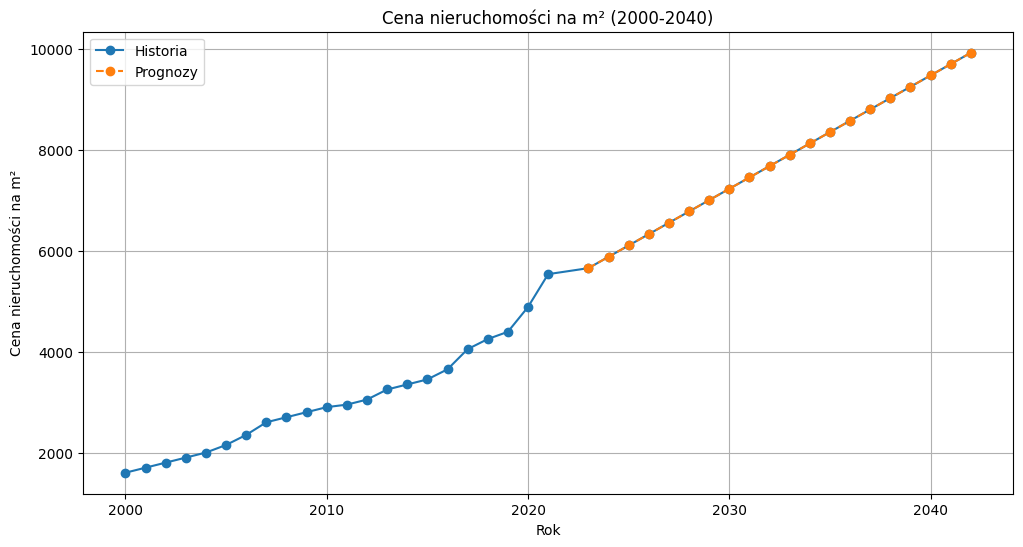

In [24]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import autopep8
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split

data = {
    'year': [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022],
    'price_m2': [1600, 1700, 1800, 1900, 2000, 2150, 2350, 2600, 2700, 2800, 2900, 2950, 3050, 3250, 3350, 3450, 3650, 4050, 4250, 4394, 4886, 5537, 6319],
    'inflation': [0.101, 0.055, 0.019, 0.007, 0.035, 0.021, 0.01, 0.025, 0.042, 0.035, 0.026, 0.039, 0.037, 0.009, 0.001, -0.009, -0.002, 0.016, 0.012, 0.023, 0.034, 0.051, 0.144],
    'i_rates': [0.19, 0.115, 0.07, 0.0525, 0.0575, 0.045, 0.04, 0.05, 0.06, 0.035, 0.035, 0.045, 0.0425, 0.025, 0.025, 0.015, 0.015, 0.015, 0.015, 0.015, 0.001, 0.001, 0.065],
    'pkb_usd': [4.04, 4.61, 5.27, 6.31, 7.35, 8.29, 9.32, 11.31, 13.95, 12.97, 13.80, 14.20, 13.83, 14.11, 14.50, 12.71, 12.37, 13.94, 15.42, 15.69, 16.26, 17.56, None],
    'sr_wynagrodzenie': [1938, 2048, 2146, 2237, 2344, 2438, 2596, 2831, 3036, 3176, 3311, 3509, 3621, 3730, 3834, 3940, 4070, 4262, 4525, 4857, 5162, 5662.53, 6346.15]
}
df = pd.DataFrame(data)

df = df.dropna()

X = df[['inflation', 'i_rates', 'pkb_usd', 'sr_wynagrodzenie']]
y = df['price_m2']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = sm.add_constant(X_train)

model = sm.OLS(y_train, X_train).fit()

X_test = sm.add_constant(X_test)
y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"R^2: {r2}")
print(f"MAE: {mae}")

df['pkb_usd'] = df['pkb_usd'].interpolate()

df['inflation_diff'] = df['inflation'].diff()
df['i_rates_diff'] = df['i_rates'].diff()
df['pkb_usd_diff'] = df['pkb_usd'].diff()
df['sr_wynagrodzenie_diff'] = df['sr_wynagrodzenie'].diff()

avg_inflation_diff = df['inflation_diff'].mean()
avg_i_rates_diff = df['i_rates_diff'].mean()
avg_pkb_usd_diff = df['pkb_usd_diff'].mean()
avg_sr_wynagrodzenie_diff = df['sr_wynagrodzenie_diff'].mean()

years_to_predict = list(range(2023, 2043))
inflation_pred = df.loc[df['year'] == 2021, 'inflation'].values[0] + np.cumsum(np.full(len(years_to_predict), avg_inflation_diff))
i_rates_pred = df.loc[df['year'] == 2021, 'i_rates'].values[0] + np.cumsum(np.full(len(years_to_predict), avg_i_rates_diff))
pkb_usd_pred = df.loc[df['year'] == 2021, 'pkb_usd'].values[0] + np.cumsum(np.full(len(years_to_predict), avg_pkb_usd_diff))
sr_wynagrodzenie_pred = df.loc[df['year'] == 2021, 'sr_wynagrodzenie'].values[0] + np.cumsum(np.full(len(years_to_predict), avg_sr_wynagrodzenie_diff))


def predict_price(inflation, i_rates, pkb_usd, sr_wynagrodzenie, model):
    X = pd.DataFrame({
        'const': [1.0],
        'inflation': [inflation],
        'i_rates': [i_rates],
        'pkb_usd': [pkb_usd],
        'sr_wynagrodzenie': [sr_wynagrodzenie]
    })
    return model.predict(X)[0]


price_m2_pred = [
predict_price(inflation, i_rates, pkb_usd, sr_wynagrodzenie, model)
for inflation, i_rates, pkb_usd, sr_wynagrodzenie in zip(inflation_pred, i_rates_pred, pkb_usd_pred, sr_wynagrodzenie_pred)
]

df_pred = pd.DataFrame({
'year': years_to_predict,
'price_m2': price_m2_pred,
'inflation': inflation_pred,
'i_rates': i_rates_pred,
'pkb_usd': pkb_usd_pred,
'sr_wynagrodzenie': sr_wynagrodzenie_pred})

df_all = pd.concat([df, df_pred], ignore_index=True)

plt.figure(figsize=(12, 6))
plt.plot(df_all['year'], df_all['price_m2'], marker='o', label='Historia')
plt.plot(df_pred['year'], df_pred['price_m2'], marker='o', linestyle='--', label='Prognozy')
plt.xlabel('Rok')
plt.ylabel('Cena nieruchomości na m²')
plt.title('Cena nieruchomości na m² (2000-2040)')
plt.grid()
plt.legend()
plt.show()

